# Introduciton

The purpose of this project is to build a classification model to predict whether a consumer's complain would get timely response or not. If the Consumer Financial Protection Bureau (CFPB) could have the insight that which complaint may not be receiving responses in time from a company, they may conduct extra measures to accelerate the process. <br>
We will use the Financial Product Consumer Complaint Data in this project. The dataset can be downloaded from https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD. A description of each variable in the dataset can be found from: https://cfpb.github.io/api/ccdb/fields.html. <br>
<br>
Author: eric-lgong

# Import Python Packages

In [1]:
%matplotlib inline
%precision 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import time
import timeit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Load the data

In [2]:
df = pd.read_csv('Consumer_Complaints.csv')
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100


In [3]:
# df.tail(3)

# Explore the entire dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871873 entries, 0 to 871872
Data columns (total 18 columns):
Date received                   871873 non-null object
Product                         871873 non-null object
Sub-product                     636713 non-null object
Issue                           871873 non-null object
Sub-issue                       399699 non-null object
Consumer complaint narrative    183903 non-null object
Company public response         242343 non-null object
Company                         871873 non-null object
State                           860657 non-null object
ZIP code                        860608 non-null object
Tags                            121641 non-null object
Consumer consent provided?      343683 non-null object
Submitted via                   871873 non-null object
Date sent to company            871873 non-null object
Company response to consumer    871873 non-null object
Timely response?                871873 non-null object
Consumer 

(1) There are **871873** records, **18** columns. <br>
(2) The **number of non-null values** for each column is also shown. <br>
(3) Feature **type** is also displayed.

In [5]:
def vars_to_drop(df, vars):
    '''
    Drop a list of columes from the DataFrame.
    vars: a list of column names;
    df: the targeting DataFrame.
    '''
    shape1 = df.shape
    df.drop(vars, axis=1, inplace=True)
    shape2 = df.shape
    print("Data shape before/after deleting: {}/{}.".format(shape1, shape2))
    return df

In [6]:
vars = ['Consumer consent provided?', 'Company response to consumer', 'Consumer disputed?', 'Complaint ID']
df = vars_to_drop(df, vars)

Data shape before/after deleting: (871873, 18)/(871873, 14).


In [7]:
# Converte 'Date received' and 'Date sent to company' to datetime format:
def conv_var_type():
    df['Date received'] = pd.to_datetime(df['Date received'])
    df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

In [8]:
# timeit.timeit(conv_var_type, number=1)                                    

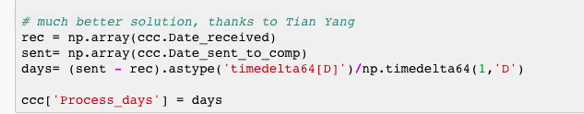

In [9]:
# df.info()

In [10]:
# df.to_csv('temp_data1.csv', index=False, encoding='utf-8')        

# Examine each feature

In [11]:
df = pd.read_csv('temp_data1.csv', encoding='utf-8')
df.shape

(871873, 15)

In [12]:
timeit.timeit(conv_var_type, number=1)

0.79

In [13]:
df.columns                                                                  

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Submitted via', 'Date sent to company',
       'Timely response?', 'Complaint ID'],
      dtype='object')

In [14]:
# create a template to check missing values
def check_var_missing_pct(df, var):
    missing_pct = df[var].isnull().sum()/df.shape[0]
    print("{:,.1%} of values are missing.".format(missing_pct))

In [15]:
# create a pie plot template
def pie(df, var, width=6, height=4):
    check_var_missing_pct(df, var)
    
    check_col = df[var].value_counts(dropna=False)                            # include 'null' values 
    labels = check_col.index.values                                           # get the row labels
    counts = check_col.values                                                 # get the counts for each value/label
    
    if len(check_col)>10:
        print('Variable levels: {}'.format(len(check_col)))
        
    if len(check_col)>50:
        return
        
    plt.figure(figsize=(width, height))
    plt.pie(counts, labels=labels, shadow=True, autopct='%1.1f%%') 
    plt.axis('equal')
    plt.title('Variable: '+var)
    plt.show()

## Check the dependent variable *'Timely response?'*.

0.0% of values are missing.


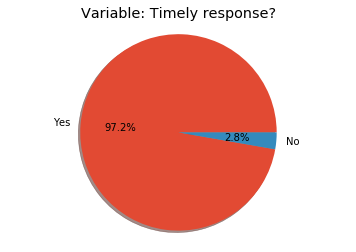

In [16]:
pie(df, 'Timely response?')

In [17]:
df.rename(columns={'Timely response?':'y'}, inplace=True)

Encode dependent variable **'y'**:

In [18]:
y_mapper = {label:idx for idx,label in enumerate(np.unique(df['y']))}
df['y'].replace(y_mapper, inplace=True)

## Check categorical independent variables.

### Check independent variable - *'Product'*.

0.0% of values are missing.
Variable levels: 18


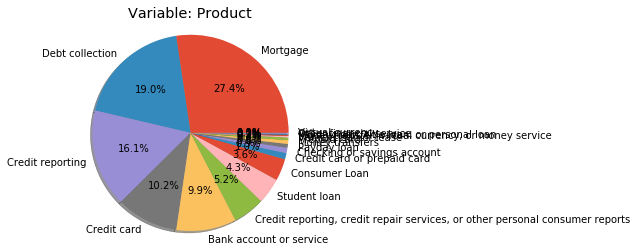

In [19]:
pie(df, 'Product')

In [20]:
# group low-occurrence values together into a new group called 'Others'
def combine_levels(df, var, thre_val, combined_label):
    var_freq = df[var].value_counts(dropna=False)
    var_pct = var_freq/var_freq.sum()
    combined_classes = var_pct.index.values[var_pct.values <= thre_val]
    combined_rows = df[var].isin(combined_classes)
    df.loc[combined_rows, var] = combined_label
    return df

0.0% of values are missing.


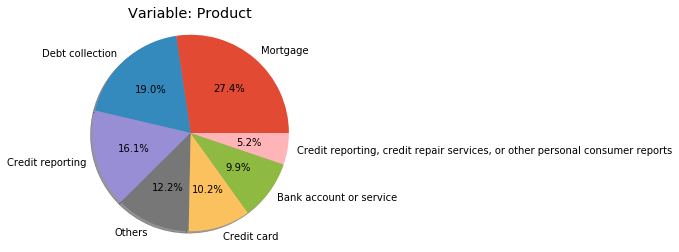

In [21]:
df = combine_levels(df, 'Product', 0.05, 'Others')
pie(df, 'Product')

![](Better_code_2.PNG)

### Check independent variable - *'Sub-product'*.

In [22]:
# pie(df, 'Sub-product')

27.0% of values are missing.


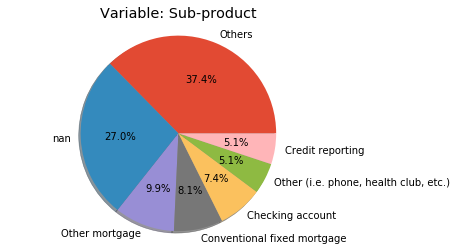

In [23]:
df = combine_levels(df, 'Sub-product', 0.05, 'Others')
pie(df, 'Sub-product')                                 

In [24]:
df = vars_to_drop(df, ['Sub-product'])

Data shape before/after deleting: (871873, 15)/(871873, 14).


### Check independent variable - *'Issue'*.

In [25]:
# pie(df, 'Issue')

0.0% of values are missing.


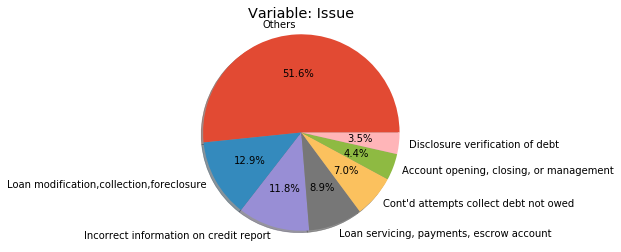

In [26]:
df = combine_levels(df, 'Issue', 0.03, 'Others')
pie(df, 'Issue')

### Check independent variable - *'Sub-issue'*.

In [27]:
pie(df, 'Sub-issue')

54.2% of values are missing.
Variable levels: 218


In [28]:
df = vars_to_drop(df, ['Sub-issue'])

Data shape before/after deleting: (871873, 14)/(871873, 13).


### Check independent variable - *'Consumer complaint narrative'*.

In [29]:
pie(df, 'Consumer complaint narrative')

78.9% of values are missing.
Variable levels: 180128


In [30]:
df = vars_to_drop(df, ['Consumer complaint narrative'])

Data shape before/after deleting: (871873, 13)/(871873, 12).


### Check independent variable - *'Company public response'*.

72.2% of values are missing.


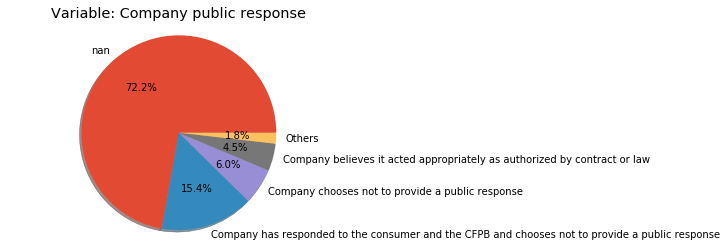

In [31]:
df = combine_levels(df, 'Company public response', 0.03, 'Others')
pie(df, 'Company public response')

In [32]:
df = vars_to_drop(df, ['Company public response'])

Data shape before/after deleting: (871873, 12)/(871873, 11).


### Check independent variable - *'Company'*.

In [33]:
pie(df, 'Company')

0.0% of values are missing.
Variable levels: 4409


In [34]:
company_appear_freq = df['Company'].value_counts(dropna=False)
# company_appear_freq

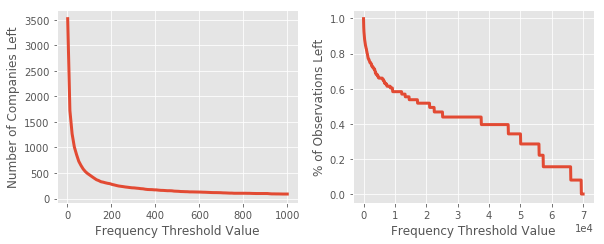

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5))

# define a series of appearance threshold values
thre1 = np.linspace(1, 1000, 100)                                              
companies_left = []

for thre_i in thre1:
    company_ct_above_thre = (company_appear_freq > thre_i).sum()
    companies_left.append(company_ct_above_thre)
ax[0].plot(thre1, companies_left, linewidth=3)
ax[0].set_xlabel('Frequency Threshold Value')
ax[0].set_ylabel('Number of Companies Left');


thre2 = np.linspace(1, 70000, 1000) 
pct_obs_left = []
for thre_i in thre2:
    obs_left = company_appear_freq.values[company_appear_freq > thre_i].sum()
    pct_obs_left.append(obs_left/df.shape[0])
ax[1].plot(thre2, pct_obs_left, linewidth=3)
ax[1].set_xlabel('Frequency Threshold Value')
ax[1].set_ylabel('% of Observations Left')
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.tight_layout()

**Question:** How to deal with the 4393 companies in the dataset? <br>
Use **MeanEncoding**!!

In [36]:
# mean encoding                                                               # need to imporve here
from sklearn.model_selection import StratifiedKFold
from itertools import product

class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode
        :param n_splits: the number of splits used in mean encoding
        :param target_type: str, 'regression' or 'classification'
        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """

        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}

        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None

        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))

    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()

        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()

        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)

        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values

        return nf_train, nf_test, prior, col_avg_y

    
    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)

        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new

    
    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()

        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits

        return X_new

In [37]:
me = MeanEncoder(categorical_features=['Company'], n_splits=10)     
df = me.fit_transform(df, df['y'])
df.head(3)

,Date received,Product,Issue,Company,State,ZIP code,Tags,Submitted via,Date sent to company,y,Complaint ID,Company_pred_0,Company_pred_1
0,2014-03-12,Mortgage,"Loan modification,collection,foreclosure",M&T BANK CORPORATION,MI,48382,NaN,Referral,2014-03-17,1,759217,0.011866,0.988134
1,2016-10-01,Credit reporting,Incorrect information on credit report,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Web,2016-10-05,1,2141773,0.001132,0.998868
2,2016-10-17,Others,Others,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Web,2016-10-20,1,2163100,0.000516,0.999484


### Check independent variable - *'State'*.

In [38]:
pie(df, 'State')

1.3% of values are missing.
Variable levels: 63


In [39]:
# remove missing values
shape1 = df.shape

df = df.loc[-df['State'].isnull(), :]
shape2 = df.shape
print("Shapes before/after deleting: {}/{}.".format(shape1, shape2))

Shapes before/after deleting: (871873, 13)/(860657, 13).


In [40]:
# mean encoding
me = MeanEncoder(categorical_features=['State'], n_splits=10)
df = me.fit_transform(df, df['y'])

In [41]:
df = vars_to_drop(df, ['ZIP code'])

Data shape before/after deleting: (860657, 15)/(860657, 14).


### Check independent variable - *'Tags'*.

86.0% of values are missing.


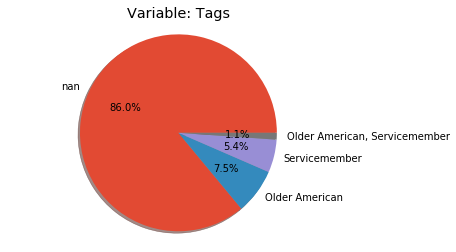

In [42]:
pie(df, 'Tags')

In [43]:
df = vars_to_drop(df, ['Tags'])

Data shape before/after deleting: (860657, 14)/(860657, 13).


### Check independent variable - *'Submitted via'*.

In [44]:
# pie(df, 'Submitted via')

0.0% of values are missing.


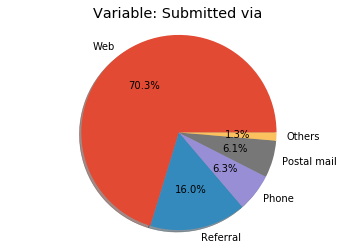

In [45]:
df = combine_levels(df, 'Submitted via', 0.05, 'Others')
pie(df, 'Submitted via')

## Check continuous independent variable(s).

In [46]:
# Create a new dataframe 'df_dt' which contains date/time info. and y:
df_dt = df[['Date received', 'Date sent to company', 'y']]
df_dt['Total Complaints'] = 1
df_dt['Timely_resp (Y)'] = np.where((df_dt['y'] == 1), 1, 0)
df_dt['Timely_resp (N)'] = np.where((df_dt['y'] == 0), 1, 0)
df_dt.head(3)

,Date received,Date sent to company,y,Total Complaints,Timely_resp (Y),Timely_resp (N)
0,2014-03-12,2014-03-17,1,1,1,0
1,2016-10-01,2016-10-05,1,1,1,0
2,2016-10-17,2016-10-20,1,1,1,0


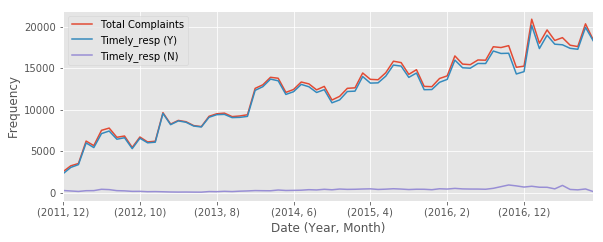

In [47]:
# plot the trend over time
df_dt[['Total Complaints', 'Timely_resp (Y)', 'Timely_resp (N)']].groupby(
    [df_dt["Date received"].dt.year, df_dt["Date received"].dt.month]).sum().plot(kind='line', figsize =(9.5, 3.5));
plt.xlabel('Date (Year, Month)')
plt.ylabel('Frequency');

del df_dt

In [48]:
# create a new variable 'Duration'.
df['Duration'] = df['Date sent to company'] - df['Date received']
df['Duration'] = pd.to_timedelta(df['Duration']).astype('timedelta64[D]')
df.describe()

,y,Complaint ID,Company_pred_0,Company_pred_1,State_pred_0,State_pred_1,Duration
count,860657.000000,8.606570e+05,860657.000000,8.606570e+05,8.606570e+05,860657.000000,860657.000000
mean,0.972412,1.441851e+06,0.026466,9.735341e-01,2.758682e-02,0.972413,3.942510
std,0.163790,7.915907e+05,0.082842,8.284186e-02,3.850946e-03,0.003851,16.588944
min,0.000000,1.000000e+00,0.000000,6.433875e-112,2.146620e-21,0.939107,-1.000000
25%,1.000000,7.681030e+05,0.001167,9.777882e-01,2.593899e-02,0.970102,0.000000
50%,1.000000,1.496935e+06,0.006711,9.932892e-01,2.789063e-02,0.972109,0.000000
75%,1.000000,2.147203e+06,0.022212,9.988331e-01,2.989849e-02,0.974061,3.000000
max,1.000000,2.688971e+06,1.000000,1.000000e+00,6.089310e-02,1.000000,1962.000000


In [49]:
# remove negative values for variable 'Duration'
shape1 = df.shape
rows_to_drop = df['Duration'] < 0
df = df.loc[-rows_to_drop, :]

shape2 = df.shape
print("Data shape before/after deleting: {}/{}.".format(shape1, shape2))

Data shape before/after deleting: (860657, 14)/(853616, 14).


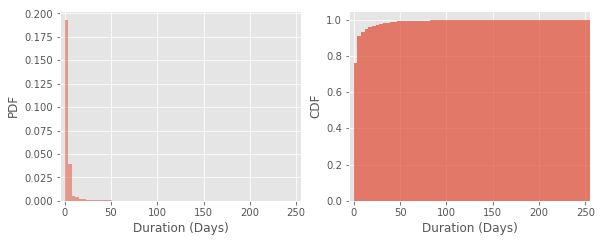

In [50]:
# plot pdf for variable 'Duration'
fig, axes = plt.subplots(1,2, figsize=(9.5, 3.5))
max_dura = 250
axes[0].hist(df['Duration'], bins=500, normed=True, cumulative=False, alpha=0.5)
axes[0].set_xlabel('Duration (Days)')
axes[0].set_xlim(-5, max_dura+5)
axes[0].set_ylabel('PDF');

# plot cdf for variable 'Duration'
bin_vals = axes[1].hist(df['Duration'], bins=500, normed=True, cumulative=True, alpha=0.7)
axes[1].set_xlabel('Duration (Days)')
axes[1].set_xlim(-5, max_dura+5)
axes[1].set_ylabel('CDF');

In [51]:
dur_ct = len(df[df['Duration'] > max_dura])
print("Records with duration > {} days: {:.0f}.".format(max_dura, dur_ct))
print("It accounts for {:,.2%}.".format(dur_ct/df.shape[0]))

Records with duration > 250 days: 458.
It accounts for 0.05%.


I will keep observations with long duration values for now.

In [52]:
durtaion_y = df[['Duration', 'y']].groupby(['y']).agg({'Duration':['mean','std']})
# durtaion_y

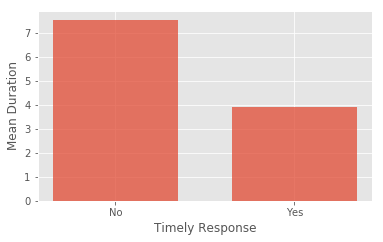

In [53]:
xvals = np.array([0,1])
plt.figure(figsize=(6, 3.5))
plt.bar(xvals, durtaion_y['Duration']['mean'], width=0.7, alpha=0.75)
plt.xticks([0,1], ['No', 'Yes'])
plt.xlabel('Timely Response')
plt.ylabel('Mean Duration');

In [54]:
# add a new variable 'Weekday' based on 'Date sent to company'
df['Weekday'] = df['Date sent to company'].dt.strftime("%a")

Check all remaining variables:

In [55]:
df.columns.values

array(['Date received', 'Product', 'Issue', 'Company', 'State',
       'Submitted via', 'Date sent to company', 'y', 'Complaint ID',
       'Company_pred_0', 'Company_pred_1', 'State_pred_0', 'State_pred_1',
       'Duration', 'Weekday'], dtype=object)

Using the following function **bar_class_var()** to plot bar chart for any categorical variable.

In [56]:
def bar_class_var(df, var, fig_wid=8, fig_ht=4):
    var_freq = df[var].value_counts()
    y_pos = np.arange(len(var_freq))
    width = var_freq.values

    plt.figure(figsize=(fig_wid, fig_ht))
    plt.barh(y_pos, width)
    plt.yticks(y_pos, var_freq.index)
    plt.xlabel('Frequency')
    plt.ylabel(var);

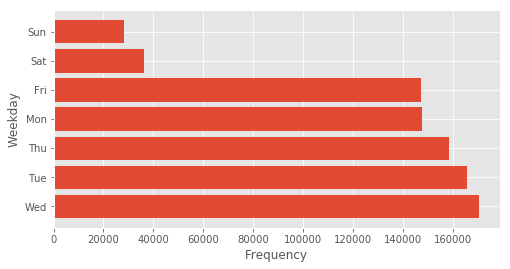

In [57]:
bar_class_var(df, 'Weekday')

# Compute relevance between i.v. and d.v.

In [58]:
print('Variables in the dataset df: \n', df.columns.values)
print('\n Shape of df: ', df.shape)

Variables in the dataset df: 
 ['Date received' 'Product' 'Issue' 'Company' 'State' 'Submitted via'
 'Date sent to company' 'y' 'Complaint ID' 'Company_pred_0'
 'Company_pred_1' 'State_pred_0' 'State_pred_1' 'Duration' 'Weekday']

 Shape of df:  (853616, 15)


**Get a new clean dataframe.** Keep **df** unchanged (for future usage).

In [59]:
df2 = df[['Duration', 'Company_pred_0', 'State_pred_0', 
          'Weekday', 'Product', 'Issue', 'Submitted via', 
          'y']]
df2.head(3)

,Duration,Company_pred_0,State_pred_0,Weekday,Product,Issue,Submitted via,y
0,5.0,0.011866,0.023391,Mon,Mortgage,"Loan modification,collection,foreclosure",Referral,1
1,4.0,0.001132,0.034049,Wed,Credit reporting,Incorrect information on credit report,Web,1
2,3.0,0.000516,0.027384,Thu,Others,Others,Web,1


Create dummy variables for categorical variables.

In [60]:
df2 = pd.get_dummies(df2, columns=['Weekday', 'Product', 'Issue', 'Submitted via'], 
                           prefix=['Weekday', 'Product', 'Issue', 'Submit_via'])
df2.head(3)

,Duration,Company_pred_0,State_pred_0,y,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,...,Issue_Disclosure verification of debt,Issue_Incorrect information on credit report,"Issue_Loan modification,collection,foreclosure","Issue_Loan servicing, payments, escrow account",Issue_Others,Submit_via_Others,Submit_via_Phone,Submit_via_Postal mail,Submit_via_Referral,Submit_via_Web
0,5.0,0.011866,0.023391,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,4.0,0.001132,0.034049,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,3.0,0.000516,0.027384,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [61]:
print('Variables in the dataset df2: \n', df2.columns.values)
print('\nShape of df2: ', df2.shape)  

Variables in the dataset df2: 
 ['Duration' 'Company_pred_0' 'State_pred_0' 'y' 'Weekday_Fri' 'Weekday_Mon'
 'Weekday_Sat' 'Weekday_Sun' 'Weekday_Thu' 'Weekday_Tue' 'Weekday_Wed'
 'Product_Bank account or service' 'Product_Credit card'
 'Product_Credit reporting'
 'Product_Credit reporting, credit repair services, or other personal consumer reports'
 'Product_Debt collection' 'Product_Mortgage' 'Product_Others'
 'Issue_Account opening, closing, or management'
 "Issue_Cont'd attempts collect debt not owed"
 'Issue_Disclosure verification of debt'
 'Issue_Incorrect information on credit report'
 'Issue_Loan modification,collection,foreclosure'
 'Issue_Loan servicing, payments, escrow account' 'Issue_Others'
 'Submit_via_Others' 'Submit_via_Phone' 'Submit_via_Postal mail'
 'Submit_via_Referral' 'Submit_via_Web']

Shape of df2:  (853616, 30)


0.0% of values are missing.


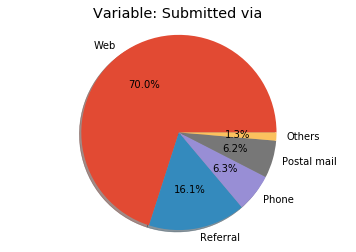

In [62]:
# using pie chart to determine which level will be removed, if necessary
var = 'Submitted via'
pie(df, var)

In [63]:
vars = ['Weekday_Sun', 'Product_Credit reporting, credit repair services, or other personal consumer reports', 
        'Issue_Disclosure verification of debt', 'Submit_via_Postal mail']
df2 = vars_to_drop(df2, vars)

Data shape before/after deleting: (853616, 30)/(853616, 26).


In [64]:
df2.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('Reds'), axis=1)          

,Duration,Company_pred_0,State_pred_0,y,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Thu,Weekday_Tue,Weekday_Wed,Product_Bank account or service,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Mortgage,Product_Others,"Issue_Account opening, closing, or management",Issue_Cont'd attempts collect debt not owed,Issue_Incorrect information on credit report,"Issue_Loan modification,collection,foreclosure","Issue_Loan servicing, payments, escrow account",Issue_Others,Submit_via_Others,Submit_via_Phone,Submit_via_Referral,Submit_via_Web
Duration,1.0,0.061,0.0046,-0.036,-0.0012,0.017,-0.037,0.006,0.01,0.00044,-0.02,-0.021,0.0051,0.014,0.04,-0.0073,-0.011,0.0082,0.016,0.061,-0.012,-0.046,0.02,0.011,0.053,-0.088
Company_pred_0,0.061,1.0,0.034,-0.49,-0.0018,5.9e-05,-0.0076,0.00082,0.00079,0.007,-0.035,-0.067,-0.11,0.24,-0.022,-0.0071,-0.022,0.12,-0.095,-0.019,-0.019,0.0046,-0.0048,0.0078,-0.034,0.039
State_pred_0,0.0046,0.034,1.0,-0.02,0.00022,-0.0051,0.0084,1.6e-05,-0.00039,-0.00094,-0.04,-0.03,0.017,0.05,-0.025,0.0066,-0.023,0.025,0.014,-0.019,-0.0025,-0.0032,-0.0095,-0.013,-0.044,0.054
y,-0.036,-0.49,-0.02,1.0,-0.019,0.0094,-0.0032,-0.0016,0.007,0.0035,0.0036,0.034,0.068,-0.13,0.026,-0.0023,0.00049,-0.07,0.057,0.02,0.016,-0.0065,0.0024,-0.0058,0.019,-0.021
Weekday_Fri,-0.0012,-0.0018,0.00022,-0.019,1.0,-0.21,-0.096,-0.22,-0.22,-0.23,0.0067,-0.0036,-0.01,-0.0092,0.0063,0.0033,0.0025,-0.0061,-0.0093,0.0073,0.0011,0.0035,0.00095,0.0064,0.016,-0.02
Weekday_Mon,0.017,5.9e-05,-0.0051,0.0094,-0.21,1.0,-0.096,-0.22,-0.22,-0.23,0.0071,0.0019,-0.00089,-0.0043,0.0067,-0.0027,0.0063,0.00049,-0.00057,0.0045,0.0043,-0.0073,0.0043,0.0079,0.024,-0.027
Weekday_Sat,-0.037,-0.0076,0.0084,-0.0032,-0.096,-0.096,1.0,-0.1,-0.1,-0.11,-0.017,0.0037,0.017,0.015,-0.053,0.002,-0.01,0.014,0.0098,-0.047,-0.015,0.029,-0.021,-0.046,-0.078,0.12
Weekday_Thu,0.006,0.00082,1.6e-05,-0.0016,-0.22,-0.22,-0.1,1.0,-0.23,-0.24,0.00063,-0.0019,-0.0038,0.0019,0.0091,0.0025,-0.00062,-0.00041,-0.00086,0.0096,0.0018,-0.0079,0.0037,0.0095,0.012,-0.022
Weekday_Tue,0.01,0.00079,-0.00039,0.007,-0.22,-0.22,-0.1,-0.23,1.0,-0.24,0.00049,0.0044,-0.00021,-0.0062,0.014,-0.0049,-0.00019,-0.0047,-0.00059,0.011,0.0054,-0.0064,0.0046,0.0051,0.013,-0.016
Weekday_Wed,0.00044,0.007,-0.00094,0.0035,-0.23,-0.23,-0.11,-0.24,-0.24,1.0,0.0049,-0.0049,-0.0053,0.00043,0.011,0.00029,0.0039,-0.003,-0.0017,0.01,0.00058,-0.0054,0.0064,0.013,0.0089,-0.023


# Model fitting using Logistic classifiers. 

Define a function to plot confusion matrix.

In [126]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print("Precision for Class 0 and Class 1 are {:.4f} and {:.4f}".format(cm[0,0], cm[1,1]))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Define a function which will help us evaluate models and perform cross-validation

In [72]:
def modelfit(alg, dtrain, predictors, standard=False, weight0='None', performCV=True, cv_folds=4, plot_con_matrix=True,  print_time=True):
    '''
    weight0: is an interger. representing the weight for Class 0.
    '''
    t1 = time.time()
    
    # prepare the datasets
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain['y'], random_state=0, stratify=dtrain['y'])
    print('shape of X_train: {}'.format(X_train.shape))
    print('shape of y_train: {}'.format(y_train.shape))
    
    # standardization
    if standard:
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaler.fit(X_train[['Duration', 'State_pred_0']])
        X_train[['Duration', 'State_pred_0']] = scaler.transform(X_train[['Duration', 'State_pred_0']])
        X_test[['Duration', 'State_pred_0']] = scaler.transform(X_test[['Duration', 'State_pred_0']])

    # Fit the algorithm on the data
    if weight0=='None':
        alg.fit(X_train, y_train)
    else:
        weight = np.where((y_train==0), weight0, 1)
        print('shape of weight: {}'.format(weight.shape))
        alg.fit(X_train, y_train, sample_weight=weight)
    
    
    # Predict the test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, dtest_predictions)
    np.set_printoptions(precision=4)
    
    # Plot normalized confusion matrix
    if plot_con_matrix:
        print("Model Report")
        plt.figure()
        class_names = ['Class 0', 'Class 1']
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    
    # Perform cross-validation:
    if performCV:
        if weight0=='None':
            cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['y'], 
                                                        cv=cv_folds, scoring='roc_auc', n_jobs=-1)
            mean_AUC_score = np.mean(cv_score)
            print("AUC Score : Mean - {:.4f} | Std - {:.4f} | Min - {:.4f} | Max - {:.4f}".format(
                np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        else:
            cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['y'], 
                                                        cv=cv_folds, scoring='roc_auc', n_jobs=-1, fit_params={'sample_weight':weight})
            mean_AUC_score = np.mean(cv_score)
            print("AUC Score : Mean - {:.4f} | Std - {:.4f} | Min - {:.4f} | Max - {:.4f}".format(
                np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    # Ouput time info.
    if print_time:
        t2 = time.time()
        print("Elapsed time is: {:.2f} s.".format(t2-t1))
    
    return mean_AUC_score

**Step 1**: Fit a baseline model (before feature selection).

Model Report
Normalized confusion matrix:
[[ 0.232   0.768 ]
 [ 0.0029  0.9971]]
AUC Score : Mean - 0.8461 | Std - 0.0067 | Min - 0.8368 | Max - 0.8537
Elapsed time is: 27.02 s.


0.85

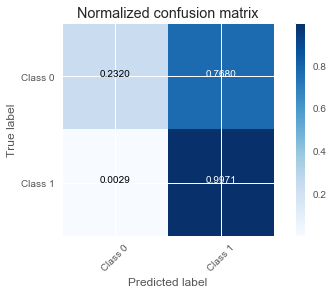

In [185]:
# Prepare data
train = df2.copy()
predictors = [x for x in train.columns if x not in ['y']]

# Fit the model
logit0 = LogisticRegression()
modelfit(logit0, train, predictors);

**Step 2**: Select features.

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

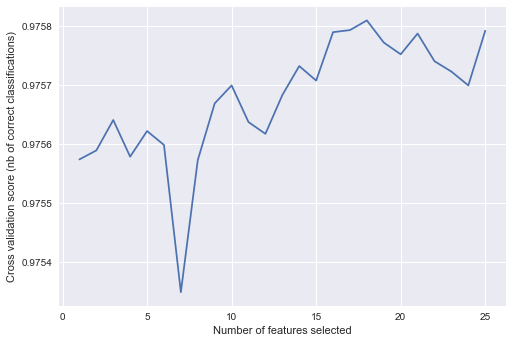

1621.38

In [70]:
# Create the RFE object and compute a cross-validated score.
t1 = time.time()

# how to control model complexity for random forest models?
clf = RandomForestClassifier(n_estimators=50, min_samples_split=20, n_jobs=-1, random_state=42)

# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(7, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n(nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'o')
plt.show()

t2 = time.time()
print("Elapsed time is: {:.2f} s.".format(t2-t1))

In [71]:
print("Total number of features: {}".format(X.shape[1]))
print("Optimal number of features : %d" % rfecv.n_features_)

Total number of features: 25
Optimal number of features : 18


In [72]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 8, 1, 3, 6, 7, 1, 5, 1,
       1, 1])

In [73]:
col_to_keep = list(X.columns.values[rfecv.ranking_ <= 1])
print(col_to_keep)

train_sclected = df2[col_to_keep].copy()

['Duration', 'Company_pred_0', 'State_pred_0', 'Weekday_Fri', 'Weekday_Mon', 'Weekday_Sat', 'Weekday_Thu', 'Weekday_Tue', 'Weekday_Wed', 'Product_Bank account or service', 'Product_Credit reporting', 'Product_Debt collection', 'Product_Mortgage', "Issue_Cont'd attempts collect debt not owed", 'Issue_Others', 'Submit_via_Phone', 'Submit_via_Referral', 'Submit_via_Web']


In [166]:
# col_to_keep = ['Duration', 'Company_pred_0', 'State_pred_0', 'Weekday_Fri', 'Weekday_Mon', 'Weekday_Sat', 'Weekday_Thu', 'Weekday_Tue', 'Weekday_Wed', 'Product_Bank account or service', 'Product_Credit reporting', 'Product_Debt collection', 'Product_Mortgage', "Issue_Cont'd attempts collect debt not owed", 'Issue_Others', 'Submit_via_Phone', 'Submit_via_Referral', 'Submit_via_Web']

** Step 3:** Re-evaluate the models **based on selected features only**.

Model Report
Normalized confusion matrix:
[[ 0.2322  0.7678]
 [ 0.0029  0.9971]]
AUC Score : Mean - 0.8520 | Std - 0.0069 | Min - 0.8407 | Max - 0.8589
Elapsed time is: 25.09 s.


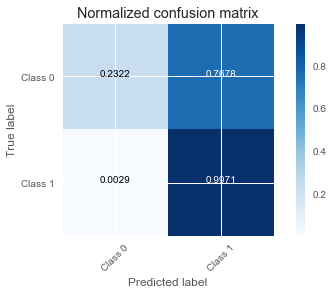

In [167]:
# Prepare data
train = df2.copy()
col_to_keep = ['Duration', 'Company_pred_0', 'State_pred_0', 'Weekday_Fri', 'Weekday_Mon', 'Weekday_Sat', 'Weekday_Thu', 
               'Weekday_Tue', 'Weekday_Wed', 'Product_Bank account or service', 'Product_Credit reporting', 
               'Product_Debt collection', 'Product_Mortgage', "Issue_Cont'd attempts collect debt not owed", 
               'Issue_Others', 'Submit_via_Phone', 'Submit_via_Referral', 'Submit_via_Web']
predictors = col_to_keep

# Fit the model
logit1_selected = LogisticRegression()
modelfit(logit1_selected, train, predictors);

The improvements in model performances are **not significant**. The mean AUC score increased from **0.8461** to **0.852** only. So during the next steps, I will keep all features. 

**Step 4**: Adjust the **class_weight** parameter in Logistic model to account for the **imbalanced classes**.

Model Report
Normalized confusion matrix:
[[ 0.6444  0.3556]
 [ 0.0836  0.9164]]
AUC Score : Mean - 0.8701 | Std - 0.0083 | Min - 0.8585 | Max - 0.8783
Elapsed time is: 41.20 s.


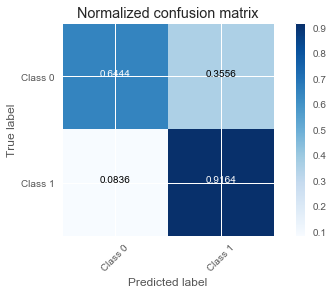

In [169]:
# Prepare data
train = df2.copy()
predictors = [x for x in train.columns if x not in ['y']]

# Fit the model
logit2_weighted = LogisticRegression(class_weight='balanced')
modelfit(logit2_weighted, train, predictors);

As shown above, the mean AUC score **increases** from **0.852** in step 3 to **0.8701**. More importantly, the confusion matrix shows that the classificaion precision on class 0 has been **significantly improved** from **0.2322** to **0.6444**. **Conclusion: accounting for imbalanced classes is very important for Logistic model in this case.**

** Step 5**: Standardization.

In [189]:
train.describe()

,Duration,Company_pred_0,State_pred_0,y,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Thu,Weekday_Tue,Weekday_Wed,...,"Issue_Account opening, closing, or management",Issue_Cont'd attempts collect debt not owed,Issue_Incorrect information on credit report,"Issue_Loan modification,collection,foreclosure","Issue_Loan servicing, payments, escrow account",Issue_Others,Submit_via_Others,Submit_via_Phone,Submit_via_Referral,Submit_via_Web
count,853616.000000,853616.000000,8.536160e+05,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,...,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000,853616.000000
mean,3.983278,0.026521,2.758476e-02,0.972276,0.172435,0.172976,0.042470,0.185558,0.193905,0.199593,...,0.043353,0.069965,0.118669,0.129807,0.089349,0.513261,0.013498,0.063242,0.160932,0.700445
std,16.651121,0.082974,3.850402e-03,0.164182,0.377758,0.378227,0.201659,0.388750,0.395355,0.399695,...,0.203651,0.255088,0.323399,0.336091,0.285247,0.499824,0.115394,0.243397,0.367468,0.458063
min,0.000000,0.000000,2.146620e-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001167,2.593899e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.006711,2.789063e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,0.022212,2.989849e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1962.000000,1.000000,6.089310e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As shown below, the variables **'Duration'** and **'State_pred_0'** are not distributed between 0 and 1.

Model Report
Normalized confusion matrix:
[[ 0.6463  0.3537]
 [ 0.0847  0.9153]]
AUC Score : Mean - 0.8701 | Std - 0.0083 | Min - 0.8585 | Max - 0.8783
Elapsed time is: 37.22 s.


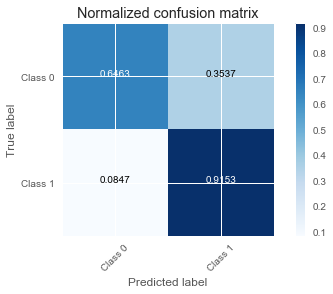

In [195]:
# Fit the model using standardized data
logit3_standard = LogisticRegression(class_weight='balanced')
modelfit(logit3_standard, train, predictors, standard=True);

As shown above, the mean AUC score remain unchanged after standardization. However, the TNR rate for Class 0 slightly increases from **0.6444** to **0.6463**. 

# Improve model performance using Gradient Boosting Machines (GBM)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier  # GBM algorithm
from sklearn import cross_validation, metrics            # Additional scklearn functions
from sklearn.grid_search import GridSearchCV             # Perforing grid search
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 9, 3.5

Prepare the dataset.

In [122]:
predictors = [x for x in df2.columns if x not in ['y']]
train = df2.copy()

Define a function to facilitate tunning parameters in GBMs.

In [138]:
def bgm_modelfit(alg, dtrain, predictors, weight0='None', plot_con_matrix=True,  print_time=True):
    '''
    weight0: is an interger. representing the weight for Class 0.
    '''
    t1 = time.time()
    
    # prepare the datasets
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain['y'], random_state=0, stratify=dtrain['y'])

    # Fit the algorithm on the data
    if weight0=='None':
        alg.fit(X_train, y_train)
    else:
        weight = np.where((y_train==0), weight0, 1)
        alg.fit(X_train, y_train, sample_weight=weight)
    
    
    # Predict the test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, dtest_predictions)
    np.set_printoptions(precision=4)

    
    # Plot normalized confusion matrix
    if plot_con_matrix:
        plt.figure()
        class_names = ['Class 0', 'Class 1']
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    else:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Precision for Class 0 and Class 1 are {:.4f} and {:.4f}".format(cnf_matrix[0,0], cnf_matrix[1,1]))
    
    # compute and print AUC score
    AUC_score = metrics.roc_auc_score(y_test, dtest_predprob)
    print("AUC Score : %f" % AUC_score)
        
    # Ouput time info.
    if print_time:
        t2 = time.time()
        print("Elapsed time is: {:.2f} s.\n".format(t2-t1))
    
    return AUC_score

## Creating a baseline model 

### Without considering sample weight

Model Report for baselie GBM model :
Precision for Class 0 and Class 1 are 0.2178 and 0.9978
AUC Score : 0.907908


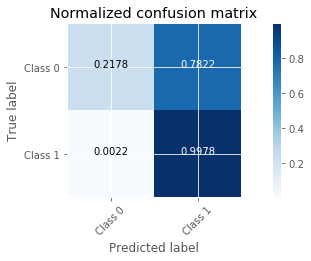

In [127]:
gbm0 = GradientBoostingClassifier(learning_rate=0.1, random_state=10)
print("Model Report for baselie GBM model :")
AUC_score = bgm_modelfit(gbm0, train, predictors, weight0=1, plot_con_matrix=True, print_time=False)

The AUC score of the base GBM model is **0.9079** and is higher than the best Logistic model (AUC score is **0.8701**). However, the confusion matrix shows that precision rate for Class 0 in the base GBM (only **0.2178**) is much lower than the Logistic model (which is 0.6463). For comparison, I will introduce **sample weights** in the next step.

### Considering sample weight

Model Report for baselie GBM model (accounting for sample weight):
Precision for Class 0 and Class 1 are 0.8154 and 0.8511
AUC Score : 0.912957


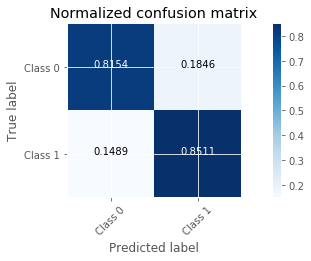

In [131]:
gbm1 = GradientBoostingClassifier(learning_rate=0.1, random_state=10)
print("Model Report for baselie GBM model (accounting for sample weight):")
AUC_score = bgm_modelfit(gbm1, train, predictors, weight0=37, plot_con_matrix=True, print_time=False);

**Findings:**
1. The TNR for the test dataset drastically increases to 0.8154. Therefore, accounting for sample weights will increase model performance.
2. Since the traning score (0.8489) is slightly lower than the test socre (0.8501), so using a lower weight might yield better results. 
3. We can expect that the model performance will be further improved after parameter tunning.

### Adjusting sample weights for class0

In [139]:
weights0_vals = [1000, 500, 200, 150, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5, 1]
AUC_scores = []

gbm2_searchweight = GradientBoostingClassifier(learning_rate=0.1, random_state=10)
for w in weights0_vals:
    print("Model Report for baselie GBM model (adjusting parameter {} = {}) :".format('Weight Class 0', w))
    AUC_score = bgm_modelfit(gbm2_searchweight, train, predictors, weight0=w, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)

Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 1000) :
Precision for Class 0 and Class 1 are 0.9980 and 0.2513
AUC Score : 0.908325
Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 500) :
Precision for Class 0 and Class 1 are 0.9927 and 0.3219
AUC Score : 0.909087
Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 200) :
Precision for Class 0 and Class 1 are 0.9755 and 0.4943
AUC Score : 0.911110
Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 150) :
Precision for Class 0 and Class 1 are 0.9692 and 0.5304
AUC Score : 0.910829
Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 100) :
Precision for Class 0 and Class 1 are 0.9454 and 0.6223
AUC Score : 0.911321
Model Report for baselie GBM model (adjusting parameter Weight Class 0 = 90) :
Precision for Class 0 and Class 1 are 0.9378 and 0.6480
AUC Score : 0.911641
Model Report for baselie GBM model (adjusting parameter We

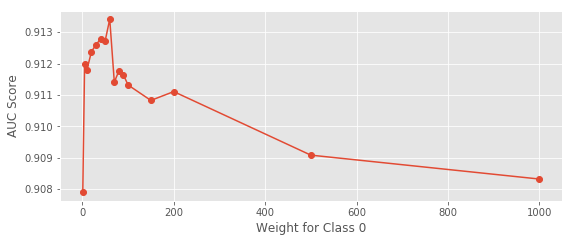

In [140]:
plt.plot(weights0_vals, AUC_scores, 'o-', label="GBMs")
plt.xlabel('Weight for Class 0')
plt.ylabel('AUC Score');

The AUC scores in the GBM models are higher than the best Logistic regression model fitted previously (AUC score = 0.8701). The classification accuracy for Class 0 increases as its weight increases (correspondingly, the classification accuracy for Class 1 decreases). For comparison purposes, I will set the weight for Class 0 as 20 (i.e., **weight0=20**). By doing so, the classification accuracy for Class 0 and Class 1 are **0.7353** and **0.9028** and is comparable to the Logistic Regression model (**0.6463** and **0.9153**). This model will be used as the base GBM model.

## General parameter tunning strategy.
1. Choose a relatively **high learning rate**. Generally the default value of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems
2. Determine the **optimum number of trees for this learning rate**. This could range around 30-300. Depends on system configurations. This is because it will be used for testing various scenarios and determining the tree parameters.
3. **Tune tree-specific parameters** for decided learning rate and number of trees. 
4. **Lower the learning rate** and increase the estimators proportionally to get more robust models.

## Fix learning rate and number of estimators for tuning tree-based parameters.
1. **min_samples_split = 500** : This should be ~0.5-1% of total values. Since this is imbalanced class problem, I'll take a much smaller value.
2. **min_samples_leaf = 100** : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
3. **max_depth = 8** : Should be chosen (5-8) based on the number of observations and predictors. This has 853K rows and 25 columns so lets take 8 here.
4. **max_features = ‘sqrt’** : Its a general thumb-rule to start with square root.
5. **subsample = 0.8** : This is a commonly used used start value.
6. **learning_rate=0.1**: This is the default value.

### Tune parameter 'n_estimators' from 30 to 300 in steps of 30.

In [141]:
no_of_trees = range(30,401,30)
AUC_scores = []

for n_estimator in no_of_trees:
    print("Model Report for parameter {} = {} :".format('n_estimators', n_estimator))
    gbm_search3 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                             n_estimators=n_estimator, min_samples_split=500, min_samples_leaf=100, 
                                             max_depth=8, max_features='sqrt', subsample=0.8)
    AUC_score = bgm_modelfit(gbm_search3, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)

Model Report for parameter n_estimators = 30 :
Precision for Class 0 and Class 1 are 0.7232 and 0.9076
AUC Score : 0.910923
Model Report for parameter n_estimators = 60 :
Precision for Class 0 and Class 1 are 0.7318 and 0.9075
AUC Score : 0.914343
Model Report for parameter n_estimators = 90 :
Precision for Class 0 and Class 1 are 0.7399 and 0.9071
AUC Score : 0.916124
Model Report for parameter n_estimators = 120 :
Precision for Class 0 and Class 1 are 0.7429 and 0.9070
AUC Score : 0.917319
Model Report for parameter n_estimators = 150 :
Precision for Class 0 and Class 1 are 0.7413 and 0.9076
AUC Score : 0.918147
Model Report for parameter n_estimators = 180 :
Precision for Class 0 and Class 1 are 0.7409 and 0.9086
AUC Score : 0.918171
Model Report for parameter n_estimators = 210 :
Precision for Class 0 and Class 1 are 0.7396 and 0.9092
AUC Score : 0.918042
Model Report for parameter n_estimators = 240 :
Precision for Class 0 and Class 1 are 0.7397 and 0.9090
AUC Score : 0.918055
Mod

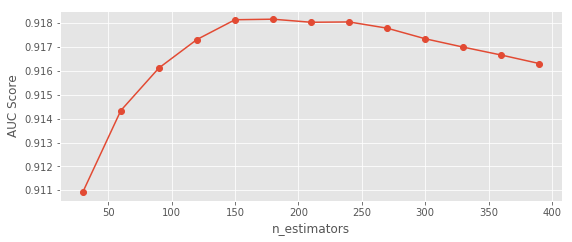

In [142]:
plt.plot(no_of_trees, AUC_scores, 'o-')
plt.xlabel('n_estimators')
plt.ylabel('AUC Score');

Based on the model output, I will use **'n_estimators'=180** for now.

### Tune **max_depth* and *num_samples_split**. 
1. **max_depth**: from 3 to 13 in steps of 2.
2. **min_samples_split**: from 200 to 1000 in steps of 200.

Model Report for parameter num_samples_splits = 200, max_depths = 3 :
Precision for Class 0 and Class 1 are 0.7137 and 0.9094
AUC Score : 0.907831
Model Report for parameter num_samples_splits = 200, max_depths = 5 :
Precision for Class 0 and Class 1 are 0.7367 and 0.9051
AUC Score : 0.915751
Model Report for parameter num_samples_splits = 200, max_depths = 7 :
Precision for Class 0 and Class 1 are 0.7413 and 0.9066
AUC Score : 0.917267
Model Report for parameter num_samples_splits = 200, max_depths = 9 :
Precision for Class 0 and Class 1 are 0.7291 and 0.9102
AUC Score : 0.916031
Model Report for parameter num_samples_splits = 200, max_depths = 11 :
Precision for Class 0 and Class 1 are 0.7130 and 0.9158
AUC Score : 0.912628
Model Report for parameter num_samples_splits = 200, max_depths = 13 :
Precision for Class 0 and Class 1 are 0.6916 and 0.9212
AUC Score : 0.909359
Model Report for parameter num_samples_splits = 400, max_depths = 3 :
Precision for Class 0 and Class 1 are 0.7137 a

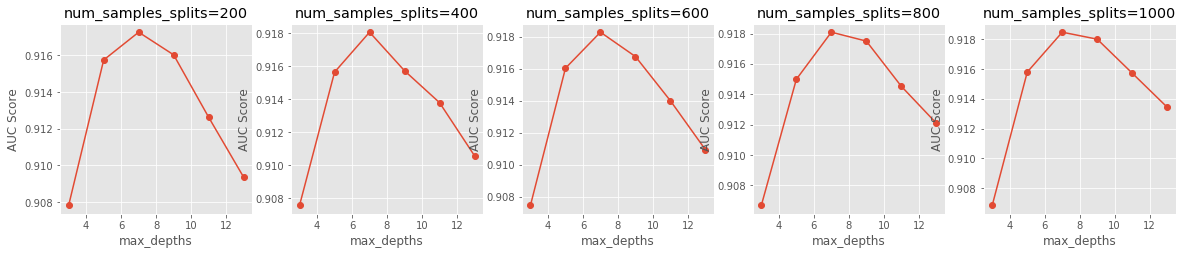

In [149]:
num_samples_splits = range(200,1001,200)
max_depths = range(3,14,2)

fig, axes = plt.subplots(1, 5, figsize=(20, 3.5))
for i, n_samples_split in enumerate(num_samples_splits):
    AUC_scores = []
    for m_depth in max_depths:
        print("Model Report for parameter {} = {}, {} = {} :".format('min_samples_split', n_samples_split, 'max_depths', m_depth))
        gbm_search4 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                                 n_estimators=180, min_samples_split=n_samples_split, min_samples_leaf=100, 
                                                 max_depth=m_depth, max_features='sqrt', subsample=0.8)
        AUC_score = bgm_modelfit(gbm_search4, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
        AUC_scores.append(AUC_score)
        
    axes[i].plot(max_depths, AUC_scores, 'o-')
    axes[i].set_xlabel('max_depths')
    axes[i].set_ylabel('AUC Score')
    title_name = 'num_samples_splits=' + str(n_samples_split)
    axes[i].set_title(title_name);

As one can see in the above figures, the AUC socre achieves the highest value when **'max_depths'=7**. <br>
The impact of using different values for **'num_samples_splits'** is marginal: 
> When num_samples_splits =  200, max_depths = 7, precision for Class 0 and Class 1 are 0.7413 and 0.9066, AUC Score : 0.917267<br>
> When num_samples_splits =  400, max_depths = 7, precision for Class 0 and Class 1 are 0.7426 and 0.9066, AUC Score : 0.918046<br>
> When num_samples_splits =  600, max_depths = 7, precision for Class 0 and Class 1 are 0.7423 and 0.9064, AUC Score : 0.918287<br>
> When num_samples_splits =  800, max_depths = 7, precision for Class 0 and Class 1 are 0.7456 and 0.9060, AUC Score : 0.918087<br>
> When num_samples_splits = 1000, max_depths = 7, precision for Class 0 and Class 1 are 0.7468 and 0.9060, AUC Score : 0.918461<br>

Also, the AUC score and the precision rate for Class 0 achieve the highest when **num_samples_splits = 1000**, so I will test a greater range of values for **num_samples_splits** in the next step.

In [ ]:
num_samples_splits = range(200,2001,200)
AUC_scores = []

for n_samples_split in num_samples_splits:
    print("Model Report for parameter {} = {} :".format('num_samples_splits', n_samples_split))
    gbm_search4 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                             n_estimators=180, min_samples_split=n_samples_split, min_samples_leaf=100, 
                                             max_depth=7, max_features='sqrt', subsample=0.8)
    AUC_score = bgm_modelfit(gbm_search4, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)

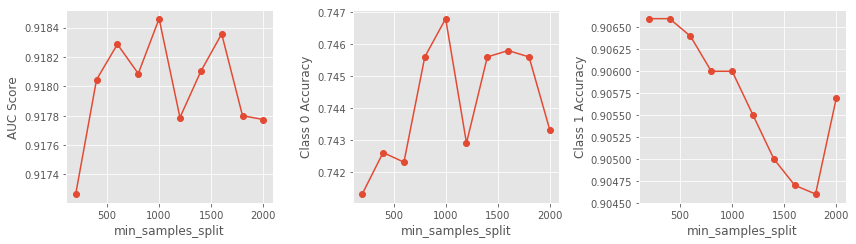

In [158]:
Class0_accu = [0.7413, 0.7426, 0.7423, 0.7456, 0.7468, 0.7429, 0.7456, 0.7458, 0.7456, 0.7433]
Class1_accu = [0.9066, 0.9066, 0.9064, 0.9060, 0.9060, 0.9055, 0.9050, 0.9047, 0.9046, 0.9057]

fig, axes = plt.subplots(1,3,figsize=(12, 3.5))
axes[0].plot(num_samples_splits, AUC_scores, 'o-')
axes[0].set_xlabel('min_samples_split')
axes[0].set_ylabel('AUC Score');

axes[1].plot(num_samples_splits, Class0_accu, 'o-')
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('Class 0 Accuracy');

axes[2].plot(num_samples_splits, Class1_accu, 'o-')
axes[2].set_xlabel('min_samples_split')
axes[2].set_ylabel('Class 1 Accuracy');
fig.tight_layout()

I will choose **min_samples_split=1000** for now. This is because:
1. It corresponds with the highest AUC score in this case.
2. The classification accuracy for Class 0 reaches the highest value when min_samples_split=1000.
3. The classification accuracy for Class 1 is relatively good.

### Tune ‘min_samples_leaf’ based on the following values: 10, 20, 50, 100, 200, 500.

Model Report for parameter min_samples_leafs = 10 :
Precision for Class 0 and Class 1 are 0.7455 and 0.9063
AUC Score : 0.918092
Model Report for parameter min_samples_leafs = 20 :
Precision for Class 0 and Class 1 are 0.7445 and 0.9064
AUC Score : 0.918070
Model Report for parameter min_samples_leafs = 50 :
Precision for Class 0 and Class 1 are 0.7406 and 0.9069
AUC Score : 0.918106
Model Report for parameter min_samples_leafs = 100 :
Precision for Class 0 and Class 1 are 0.7468 and 0.9060
AUC Score : 0.918461
Model Report for parameter min_samples_leafs = 200 :
Precision for Class 0 and Class 1 are 0.7472 and 0.9050
AUC Score : 0.917873
Model Report for parameter min_samples_leafs = 500 :
Precision for Class 0 and Class 1 are 0.7502 and 0.9045
AUC Score : 0.918129


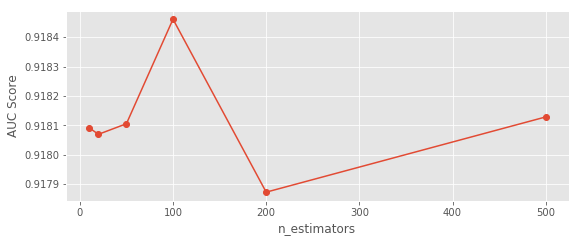

In [159]:
min_samples_leafs = [10, 20, 50, 100, 200, 500]
AUC_scores = []

for m_leafs in min_samples_leafs:
    print("Model Report for parameter {} = {} :".format('min_samples_leafs', m_leafs))
    gbm_search5 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                             n_estimators=180, min_samples_split=1000, min_samples_leaf=m_leafs, 
                                             max_depth=7, max_features='sqrt', subsample=0.8)
    AUC_score = bgm_modelfit(gbm_search5, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)
    
plt.plot(min_samples_leafs, AUC_scores, 'o-')
plt.xlabel('min_samples_leafs')
plt.ylabel('AUC Score');

Here I will set the optimum value for min_samples_leaf as 100.

### Tune the last tree-parameters, i.e. max_features by trying 6 values from 1 to 15 in steps of 2.

Model Report for parameter max_features = 1 :
Precision for Class 0 and Class 1 are 0.7269 and 0.9061
AUC Score : 0.909455
Model Report for parameter max_features = 3 :
Precision for Class 0 and Class 1 are 0.7336 and 0.9071
AUC Score : 0.914892
Model Report for parameter max_features = 5 :
Precision for Class 0 and Class 1 are 0.7468 and 0.9060
AUC Score : 0.918461
Model Report for parameter max_features = 7 :
Precision for Class 0 and Class 1 are 0.7473 and 0.9057
AUC Score : 0.920346
Model Report for parameter max_features = 9 :
Precision for Class 0 and Class 1 are 0.7533 and 0.9060
AUC Score : 0.920981
Model Report for parameter max_features = 11 :
Precision for Class 0 and Class 1 are 0.7548 and 0.9050
AUC Score : 0.921454
Model Report for parameter max_features = 13 :
Precision for Class 0 and Class 1 are 0.7544 and 0.9056
AUC Score : 0.922082
Model Report for parameter max_features = 15 :
Precision for Class 0 and Class 1 are 0.7573 and 0.9052
AUC Score : 0.922337


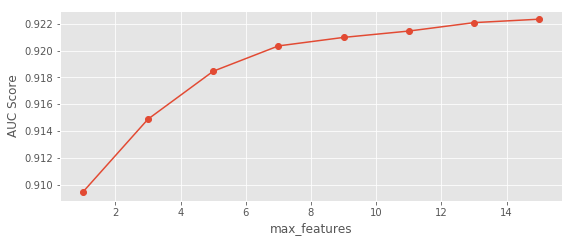

In [161]:
max_features = range(1,16,2)
AUC_scores = []

for m_feature in max_features:
    print("Model Report for parameter {} = {} :".format('max_features', m_feature))
    gbm_search6 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                             n_estimators=180, min_samples_split=1000, min_samples_leaf=100, 
                                             max_depth=7, max_features=m_feature, subsample=0.8)
    AUC_score = bgm_modelfit(gbm_search6, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)
    
plt.plot(max_features, AUC_scores, 'o-')
plt.xlabel('max_features')
plt.ylabel('AUC Score');

I will set **max_features = 9** for now. With this we have the final tree-parameters as:
	* min_samples_split: 1000
	* min_samples_leaf: 100
	* max_depth: 7
	* max_features: 9

### Tuning subsample rate.

Model Report for parameter subsample_rates = 0.6 :
Precision for Class 0 and Class 1 are 0.7536 and 0.9054
AUC Score : 0.921036
Model Report for parameter subsample_rates = 0.65 :
Precision for Class 0 and Class 1 are 0.7527 and 0.9067
AUC Score : 0.920293
Model Report for parameter subsample_rates = 0.7000000000000001 :
Precision for Class 0 and Class 1 are 0.7521 and 0.9059
AUC Score : 0.920885
Model Report for parameter subsample_rates = 0.7500000000000001 :
Precision for Class 0 and Class 1 are 0.7546 and 0.9066
AUC Score : 0.921284
Model Report for parameter subsample_rates = 0.8000000000000002 :
Precision for Class 0 and Class 1 are 0.7533 and 0.9060
AUC Score : 0.920981
Model Report for parameter subsample_rates = 0.8500000000000002 :
Precision for Class 0 and Class 1 are 0.7539 and 0.9067
AUC Score : 0.921666
Model Report for parameter subsample_rates = 0.9000000000000002 :
Precision for Class 0 and Class 1 are 0.7538 and 0.9059
AUC Score : 0.921437


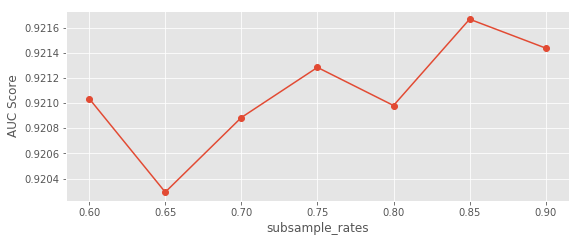

In [163]:
subsample_rates = np.arange(0.6,0.9,0.05)
AUC_scores = []

for s_sample in subsample_rates:
    print("Model Report for parameter {} = {} :".format('subsample_rates', s_sample))
    gbm_search7 = GradientBoostingClassifier(learning_rate=0.1, random_state=10, 
                                             n_estimators=180, min_samples_split=1000, min_samples_leaf=100, 
                                             max_depth=7, max_features=9, subsample=s_sample)
    AUC_score = bgm_modelfit(gbm_search7, train, predictors, weight0=20, print_time=False, plot_con_matrix=False)
    AUC_scores.append(AUC_score)
    
plt.plot(subsample_rates, AUC_scores, 'o-')
plt.xlabel('subsample_rates')
plt.ylabel('AUC Score');

Here, I found **0.85** as the optimum value.

### lower the learning rate and increase the number of estimators proportionally.

In [167]:
learn_rate_n_estimator = [(0.05, 360), (0.01, 1800), (0.005, 3600)]
AUC_scores = []

for learn_rate, n_estimator in learn_rate_n_estimator:
    print("Model Report for parameter {} = {}, {} = {} :".format('learning_rate', learn_rate, 'n_estimators', n_estimator))
    gbm_search8 = GradientBoostingClassifier(learning_rate=learn_rate, random_state=10, 
                                             n_estimators=n_estimator, min_samples_split=1000, min_samples_leaf=100, 
                                             max_depth=7, max_features=9, subsample=s_sample)
    AUC_score = bgm_modelfit(gbm_search8, train, predictors, weight0=20, print_time=True, plot_con_matrix=False)
    AUC_scores.append(AUC_score)
    
# plt.plot(subsample_rates, AUC_scores, 'o-')
# plt.xlabel('subsample_rates')
# plt.ylabel('AUC Score');

Model Report for parameter learning_rate = 0.05, n_estimators = 360 :
Precision for Class 0 and Class 1 are 0.7541 and 0.9057
AUC Score : 0.921346
Elapsed time is: 566.26 s.

Model Report for parameter learning_rate = 0.01, n_estimators = 1800 :
Precision for Class 0 and Class 1 are 0.7539 and 0.9062
AUC Score : 0.921931
Elapsed time is: 2870.56 s.

Model Report for parameter learning_rate = 0.005, n_estimators = 3600 :
Precision for Class 0 and Class 1 are 0.7541 and 0.9063
AUC Score : 0.921945
Elapsed time is: 5721.00 s.



Due to time constraints, I will choose the default **learning_rate = 0.1, n_estimators = 180**. Under these parameters, the AUC score is 0.9217; classification precision for Class 0 and Class 1 are 0.7539 and 0.9067, repectively.


##### THE END.

In [ ]:
# Questions remain unsolved: 
# basic theory of mean encoding?
# better way to create the correlation matrix?
# how does feature importance computed in the RFE object?
# importance display
# model interpretation?
# how to accelerating the modeling calibration process?
# apply Xgboost?

![](Better_code_3.PNG)